<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 - Movie Recommendation System**

### #Group21
Camilla Labbate - camillalabbate02@icloud.com

Emanuele Iaccarino - emanueleiaccarino.ei@gmail.com

Andrej Sterjev - andrej.sterjev@gmail.com

## 1. **Recommendation System with LSH**

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [ ]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory
================================================================


In [ ]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory
================================================================


In [ ]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')


dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

100%|██████████| 195M/195M [00:09<00:00, 21.0MB/s]

Extracting files...


File trovato: genome_scores.csv
File trovato: tag.csv
File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: rating.csv
File trovato: link.csv


In [ ]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


NameError: name 'cudf' is not defined

In [ ]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [ ]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

NameError: name 'ratings_df' is not defined

In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,2902,Psycho II (1983),Horror|Mystery|Thriller,86154,10576
1,2903,Psycho III (1986),Horror|Thriller,91799,12662
2,2904,Rain (1932),Drama,23369,61369
3,2905,Sanjuro (Tsubaki Sanjûrô) (1962),Action|Adventure|Drama,56443,11712
4,2906,Random Hearts (1999),Drama|Romance,156934,12618


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,67,1136,5.0,1999-12-11 16:59:54,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,71853,762
1,67,1196,4.0,1999-12-11 16:47:21,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,80684,1891
2,67,1197,5.0,1999-12-11 16:47:21,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,93779,2493
3,67,1198,5.0,1999-12-11 16:47:21,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,82971,85
4,67,1206,5.0,1999-12-11 17:24:50,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,66921,185


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,1,81,0.05450,assassin
1,1,82,0.11100,assassination
2,1,83,0.03225,assassins
3,1,84,0.27975,astronauts
4,1,85,0.09225,atheism


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,1588,318,friendship,2010-08-28 01:08:15,"Shawshank Redemption, The (1994)",Crime|Drama
1,1588,318,inspirational,2010-08-28 01:08:22,"Shawshank Redemption, The (1994)",Crime|Drama
2,1588,318,justice,2010-08-28 01:08:30,"Shawshank Redemption, The (1994)",Crime|Drama
3,1588,318,Morgan Freeman,2010-08-28 01:08:33,"Shawshank Redemption, The (1994)",Crime|Drama
4,1588,318,prison,2010-08-28 01:08:38,"Shawshank Redemption, The (1994)",Crime|Drama


In [ ]:
check_memory()

GPU Memory - Total: 9.14 GB, Used: 0.00 GB, Free: 9.14 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

### 1.1 Data Preparation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
movies_df_pd = movies_df.to_pandas()
rating_df_pd=ratings_df.to_pandas()
tags_df_pd=tags_df.to_pandas()
genome_tags_df_pd=genome_tags_df.to_pandas()
genome_scores_df_pd=genome_scores_df.to_pandas()
links_df_pd=links_df.to_pandas()

In [ ]:
print("\nInfo about dataset 'movies':")
print(movies_df_pd.info())

print("\nInfo about dataset 'ratings':")
print(rating_df_pd.info())


print("\nInfo about dataset 'tag':")
print(tags_df_pd.info())

print("\nInfo about dataset 'genome_tags':")
print(genome_tags_df_pd.info())


print("\nInfo about dataset  'genome_scores':")
print(genome_scores_df_pd.info())

print("\nInfo about dataset 'link':")
print(links_df_pd.info())

display(movies_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_tags_df_pd.head())
display(genome_scores_df_pd.head())
display(links_df_pd.head())


Info about dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Info about dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Info about dataset 'tag':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465426 non-null  int64 
 1   

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [ ]:
rating_df=rating_df_pd.drop_duplicates()
movies_df=movies_df_pd.drop_duplicates()
tags_df=tags_df_pd.drop_duplicates()
links_df=links_df_pd.drop_duplicates()
genome_scores_df=genome_scores_df_pd.drop_duplicates()
genome_tags_df=genome_tags_df_pd.drop_duplicates()


In [ ]:
print("\nexploring dataset 'ratings':")
print(rating_df_pd.describe())

print("\nexploring dataset'movies':")
print(movies_df_pd.describe(include='all'))

print("\nexploring dataset 'link':")
print(links_df_pd.describe())

print("\nexploring dataset'tag':")
print(tags_df_pd.describe(include='all'))

print("\nexploring dataset 'genome_scores':")
print(genome_scores_df_pd.describe())

print("\nexploring dataset'genome_tags':")
print(genome_tags_df_pd.describe(include='all'))


exploring dataset 'ratings':
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

exploring dataset'movies':
              movieId           title genres
count    27278.000000           27278  27278
unique            NaN           27262   1342
top               NaN  Aladdin (1992)  Drama
freq              NaN               2   4520
mean     59855.480570             NaN    NaN
std      44429.314697             NaN    NaN
min          1.000000             NaN    NaN
25%       6931.250000             NaN    NaN
50%      68068.000000             NaN    NaN
75%     100293.250000             NaN    NaN
max     131262.

In [ ]:
movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


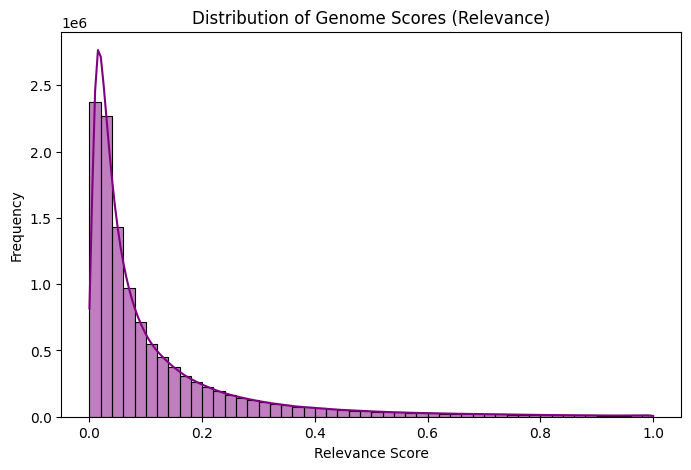

In [ ]:
plt.figure(figsize=(8, 5))
# Use the pandas DataFrame directly for plotting
sns.histplot(genome_scores_df_pd['relevance'], bins=50, kde=True, color='purple')
plt.title('Distribution of Genome Scores (Relevance)')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

There are noticeable peaks around ratings like 3.0, 4.0, and 5.0, suggesting that many users tend to give these scores.
Ratings below 2.0 are much less frequent.
The dataset might have a tendency towards higher ratings, indicating a positive skew (more ratings closer to 4 or 5).

This distribution suggests that users tend to rate movies positively, with most ratings clustering around 3 to 5. This behavior is common in user-generated rating datasets, where extreme negative ratings are less frequent.

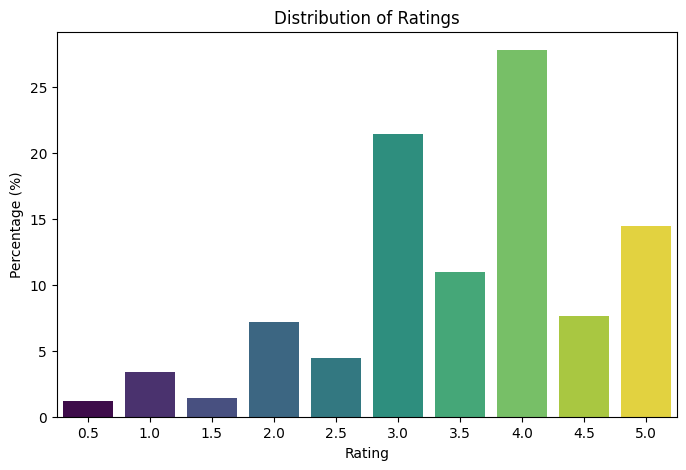

In [ ]:
rating_counts = rating_df_pd['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    x=rating_counts.index,
    y=(rating_counts.values / rating_counts.sum()) * 100,
    hue=rating_counts.index,
    palette='viridis',
    legend=False
)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.show()


This bar chart shows the distribution of ratings as percentages. The X-axis represents the rating values while the Y-axis shows the percentage of ratings for each value.

The  bar chart shows  the distribution of ratings given by users. The X-axis represents rating values (from 0.5 to 5.0), while the Y-axis shows the percentage of users who gave a specific rating.


1. **Higher ratings (4.0 - 5.0) dominate:** Most users gave high ratings like 4.0 and 5.0, represented by green and yellow bars, suggesting users tend to rate positively.
2. **Low ratings are rare:** Lower ratings (0.5 - 1.0) are less frequent, with small purple and blue bars, implying users rarely give very low scores.
3. **Overall higher distribution:** The chart's shape suggests users generally give ratings in the higher range, with a slight tilt toward lower values but no strong concentration.

The dataset shows a general tendency for users to provide favorable ratings, with few negative reviews. This could be typical of a context where reviews are mostly positive, or the ratings are influenced by a large number of maximum scores.

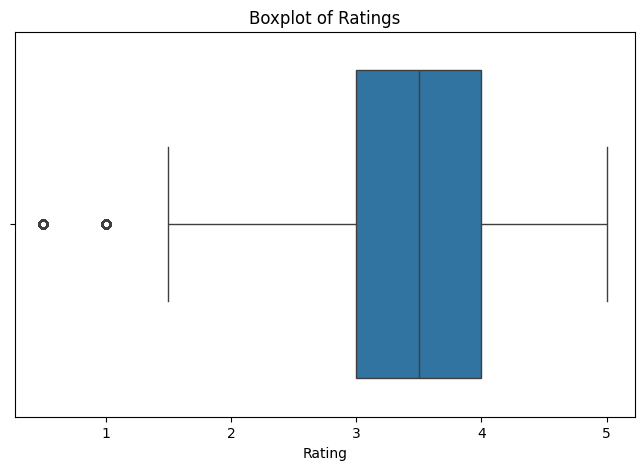

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_df_pd['rating'])
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.show()

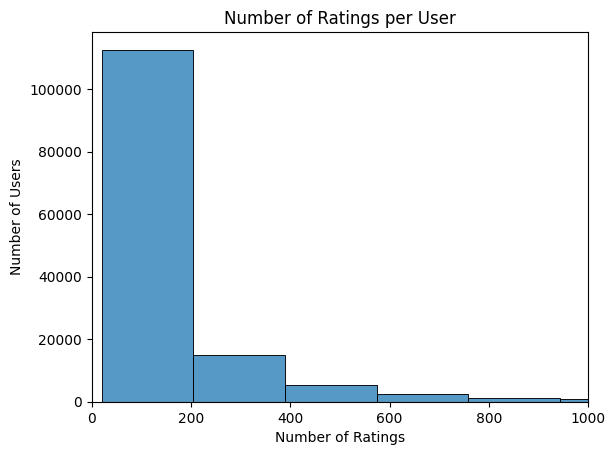

In [ ]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 1000)
plt.show()

The image shows a bar chart representing the distribution of ratings per user. The horizontal axis (x) represents the number of ratings, while the vertical axis (y) represents the number of users who have made that number of ratings.

Key findings:

1. **High peak near zero**: Most users have made a relatively low number of ratings, likely fewer than 100.
2. **Decreasing distribution**: As the number of ratings increases, the number of users decreases drastically.
3. **Limit at 1000 ratings**: The chart is limited to 1000 ratings on the x-axis, suggesting users with more than 1000 ratings are excluded or only a subset of data is being observed.

In summary, most users have left few ratings, with only a few users providing a significantly high number of ratings. This type of distribution is typical of review datasets, where a small number of users are highly active, while the majority contribute only marginally.

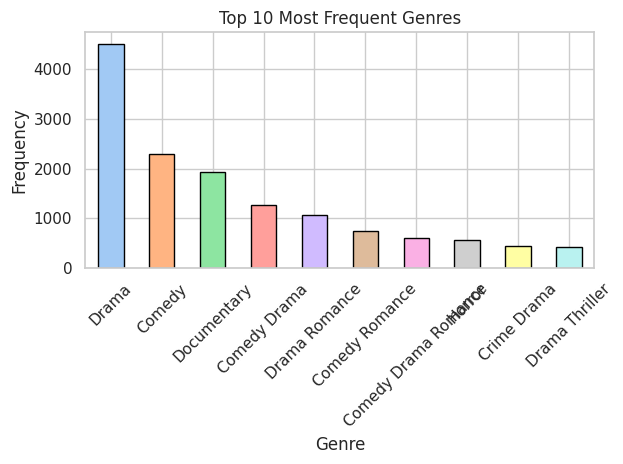

In [ ]:
movies_df_pd['genres'] = movies_df_pd['genres'].dropna().astype(str).str.split('|')

# Flatten the list of genres
all_genres = [genre for sublist in movies_df_pd['genres'] for genre in sublist]

# Count genre occurrences and get the top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot with a custom Seaborn palette
sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 10)

# Create the bar chart
genre_counts.plot(kind='bar', color=palette, edgecolor='black')

# Add titles and labels
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

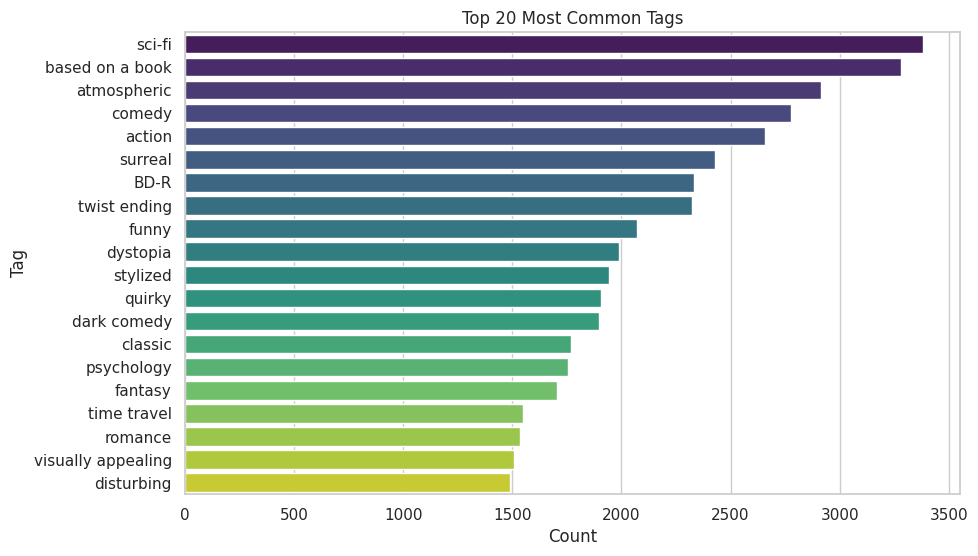

In [ ]:
tag_counts = tags_df_pd['tag'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis', hue=tag_counts.index, label=None)  # Set label to None to disable legend
plt.title('Top 20 Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

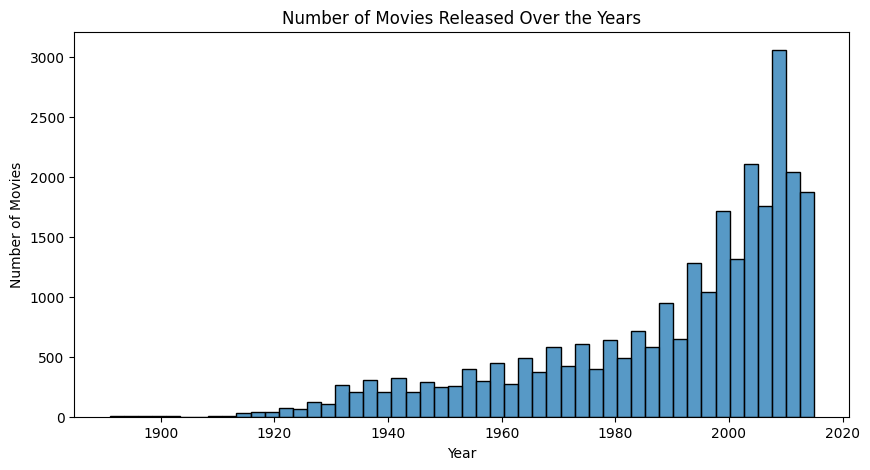

In [ ]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## 1.2 Minhash Signatures

In [ ]:
user_movies = rating_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [ ]:
def jaccard_similarity_exact(movies1, movies2):
    intersection = len(movies1 & movies2)
    union = len(movies1 | movies2)
    return intersection / union if union > 0 else 0

In [ ]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [ ]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):

    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [ ]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """"Defines a cubic hash function based on 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """"Generates a series of hash functions using the coefficient 2x in the formula.""""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [ ]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """"Defines a cubic hash function based on x^2."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """"Generates a series of hash functions using the coefficient x^2 in the formula."."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [ ]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """"Defines a cubic hash function based on x^3.""""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [ ]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """"Create MinHash signatures for a specific group of users."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:

            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:

            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [ ]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calculate the mean squared error (MSE) between real and estimated similarities for a set of users"""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Real similarity based on the Jaccard definition.
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # "Estimated similarity using MinHash signatures."
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])


            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calculate MSE
    return (total_error / pair_count) if pair_count > 0 else 0

In [ ]:
# Seleziona tutti gli utenti disponibili
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}

# Crea le famiglie di funzioni hash
hash_funcs_2x = create_hash_function_family(
    num_functions=10,
    max_movie_val=int(rating_df['movieId'].max()),  # Converti in int se necessario
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=10,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=10,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

# Calcola le firme MinHash per ogni tipo di funzione hash
signatures_2x = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_2x).items()
}

signatures_quadratic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic).items()
}

signatures_cubic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic).items()
}

print("Firme MinHash con hash lineare (2x):", list(signatures_2x.items())[:5])  # Prime 5 firme
print("Firme MinHash con hash quadratico:", list(signatures_quadratic.items())[:5])
print("Firme MinHash con hash cubico:", list(signatures_cubic.items())[:5])

mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

print("MSE 2x:", mse_2x)
print("MSE x^2:", mse_quadratic)
print("MSE x^3:", mse_cubic)


<ipython-input-44-77d7e1577b64>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


In [ ]:
print(f"MSE  2x: {mse_2x:.4f}")
print(f"MSE  x^2: {mse_quadratic:.4f}")
print(f"MSE x^3: {mse_cubic:.4f}")

MSE  2x: 0.0081
MSE  x^2: 0.0048
MSE x^3: 0.0088


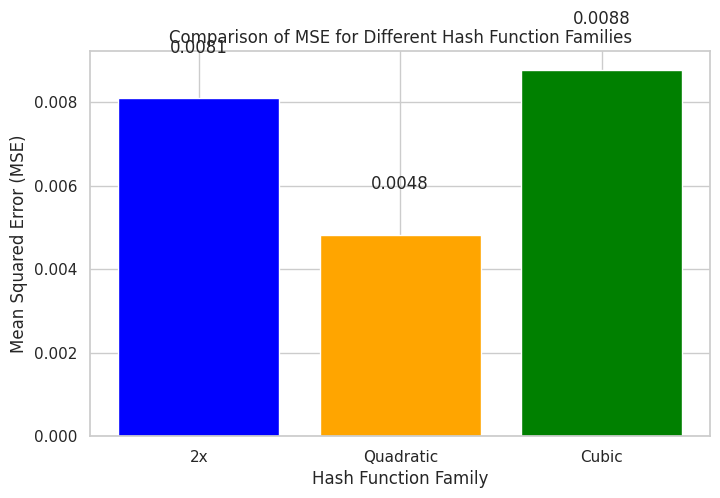

In [ ]:
hash_methods = ['2x', 'Quadratic', 'Cubic']
mse_values = [ mse_2x, mse_quadratic, mse_cubic]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(hash_methods, mse_values, color=['blue', 'orange', 'green', 'red'])

# Add labels and title
plt.title('Comparison of MSE for Different Hash Function Families')
plt.xlabel('Hash Function Family')
plt.ylabel('Mean Squared Error (MSE)')

# Display MSE values on top of each bar
for i, mse in enumerate(mse_values):
    plt.text(i, mse + 0.001, f'{mse:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()


In [ ]:
#real and estimated similarity
real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calculate the real similarity (Jaccard)
        real_sim = jaccard_similarity_exact(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # calculate the estimated similarity (Minhash)
        estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])
        estimated_similarities.append(estimated_sim)

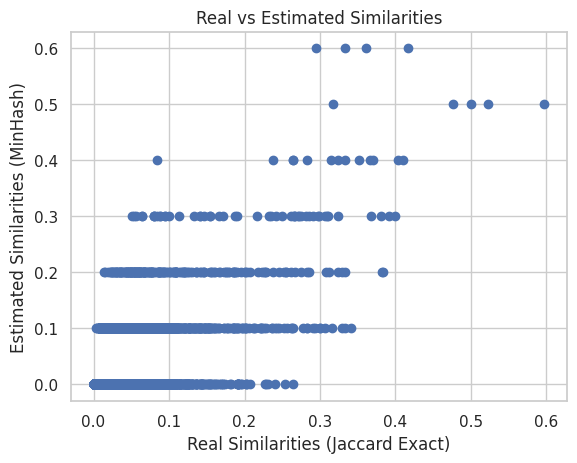

In [ ]:
plt.scatter(real_similarities, estimated_similarities)
plt.xlabel('Real Similarities (Jaccard Exact)')
plt.ylabel('Estimated Similarities (MinHash)')
plt.title('Real vs Estimated Similarities')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Thresholds from 0 to 1 with step 0.1
thresholds = np.linspace(0, 1, 11)

# Dictionary storing the precomputed MinHash signatures
hash_types = {
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Predefined MSE values for each hash type
mse_values = {
    "Linear (2x)": 0.0081,
    "Quadratic": 0.0048,
    "Cubic": 0.0088
}

# Placeholder for calculated results
results = []

# Loop through each type of hash function and threshold
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        # Calculate real and estimated similarity labels based on the threshold
        real_similarities = [jaccard_similarity_exact(user_movies[user1], user_movies[user2])
                             for user1 in selected_users for user2 in selected_users if user1 != user2]

        estimated_similarities = [jaccard_similarity_hashed(signatures[user1], signatures[user2])
                                  for user1 in selected_users for user2 in selected_users if user1 != user2]

        # Create binary labels: 1 if similarity exceeds the threshold, else 0
        real_labels = [1 if sim >= threshold else 0 for sim in real_similarities]
        estimated_labels = [1 if sim >= threshold else 0 for sim in estimated_similarities]

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(real_labels, estimated_labels, zero_division=0)
        recall = recall_score(real_labels, estimated_labels, zero_division=0)
        f1 = f1_score(real_labels, estimated_labels, zero_division=0)

        # Retrieve the MSE value for the current hash type
        mse = mse_values[hash_name]

        # Store results in a list
        results.append((hash_name, threshold, precision, recall, f1, mse))

# Convert the results list into a DataFrame for visualization
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Print the results table
print(df_results)


      Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0   Linear (2x)        0.0   1.000000  1.000000  1.000000  0.0081
1   Linear (2x)        0.1   0.239758  0.757962  0.364286  0.0081
2   Linear (2x)        0.2   0.183716  0.745763  0.294807  0.0081
3   Linear (2x)        0.3   0.340000  0.472222  0.395349  0.0081
4   Linear (2x)        0.4   0.120000  0.750000  0.206897  0.0081
5   Linear (2x)        0.5   0.040000  0.333333  0.071429  0.0081
6   Linear (2x)        0.6   0.000000  0.000000  0.000000  0.0081
7   Linear (2x)        0.7   0.000000  0.000000  0.000000  0.0081
8   Linear (2x)        0.8   0.000000  0.000000  0.000000  0.0081
9   Linear (2x)        0.9   0.000000  0.000000  0.000000  0.0081
10  Linear (2x)        1.0   0.000000  0.000000  0.000000  0.0081
11    Quadratic        0.0   1.000000  1.000000  1.000000  0.0048
12    Quadratic        0.1   0.264387  0.673036  0.379641  0.0048
13    Quadratic        0.2   0.276923  0.610169  0.380952  0.0048
14    Quad

The results provided show the performance of three different hash functions—**Linear (2x)**, **Quadratic**, and **Cubic**—evaluated at different thresholds (ranging from 0.0 to 1.0) across four key metrics: **Precision**, **Recall**, **F1-Score**, and **MSE** (Mean Squared Error).

Let's analyze the results in detail:

### 1. **Linear (2x)** Hash Function
- **Precision** starts at 1.0 for the threshold 0.0, which indicates that at this threshold, the hash function has perfect precision (it is very confident about the positives it predicts). However, as the threshold increases, precision drops significantly.
  - For example, at threshold 0.1, precision is 0.24, meaning the hash function becomes much less precise.
  - Precision drops to 0 for thresholds 0.6 and above, indicating that at higher thresholds, the hash function fails to classify any positives correctly.
- **Recall** is quite high for lower thresholds, specifically 1.0 at threshold 0.0, meaning the hash function captures all the true positives at this threshold.
  - As the threshold increases, recall drops significantly, showing the hash function's inability to maintain recall as the threshold rises.
  - Similar to precision, recall becomes 0 for thresholds from 0.6 onward.
- **F1-Score** combines both precision and recall. For lower thresholds, F1-Score is 1.0 (indicating a perfect balance of precision and recall), but it rapidly drops as thresholds increase.
  - The F1-Score continues to fall to 0 as precision and recall become 0 at higher thresholds.
- **MSE** remains constant at 0.0081 for all thresholds, indicating that the linear hash function's error does not change across thresholds.

### 2. **Quadratic Hash Function**
- **Precision** begins at 1.0 for threshold 0.0, similarly to the linear function, and decreases as the threshold increases.
  - However, precision stays higher than the linear hash function for most of the thresholds. For example, at threshold 0.1, precision is 0.26, while at threshold 0.2, it increases slightly to 0.28.
  - Precision continues to drop to 0 for thresholds from 0.6 onwards.
- **Recall** is 1.0 for threshold 0.0 (perfect recall), similar to the linear function. However, recall declines more slowly for the quadratic function.
  - Recall is significantly higher at most thresholds compared to the linear hash function. For example, recall stays above 0.44 at thresholds 0.2 and 0.3, indicating that the quadratic hash function maintains more true positives for a wider range of thresholds.
- **F1-Score** remains higher than the linear function for most thresholds. The F1-Score at threshold 0.1 is 0.38, which is better than the linear hash function's F1-Score at the same threshold.
  - At threshold 0.5, the F1-Score reaches 0.5, which is still relatively better than the linear function's performance.
  - Like precision and recall, F1-Score drops to 0 at higher thresholds.
- **MSE** remains constant at 0.0048, showing that the quadratic hash function performs with a slightly lower error rate than the linear hash function.

### 3. **Cubic Hash Function**
- **Precision** starts at 1.0 for threshold 0.0, but similar to the other functions, it decreases as the threshold increases.
  - For example, at threshold 0.1, precision is 0.2, and it remains lower than the quadratic function for most thresholds.
  - Precision drops to 0 from threshold 0.6 onward.
- **Recall** is also 1.0 at threshold 0.0, similar to both the linear and quadratic functions.
  - Recall decreases similarly to precision, and like the other functions, becomes 0 after threshold 0.6.
- **F1-Score** shows the same trend as precision and recall. At threshold 0.0, the F1-Score is 1.0 (perfect), but it rapidly drops as the threshold increases.
  - For example, at threshold 0.1, F1-Score is 0.32, which is lower than the quadratic function at the same threshold.
- **MSE** remains constant at 0.0088, indicating a higher error compared to the quadratic function (which had an MSE of 0.0048), but equal to the linear function's MSE.

### Key Observations:
- **Threshold Impact**: All three functions show similar behavior with respect to threshold changes: they have perfect performance (precision, recall, F1-Score = 1.0) at the lowest threshold (0.0), but their performance deteriorates rapidly as the threshold increases. At higher thresholds, none of the functions manage to retain both precision and recall, resulting in F1-Scores and recall values of 0.
- **MSE Comparison**: The quadratic hash function performs better in terms of MSE, with a lower error (0.0048), compared to the linear (0.0081) and cubic (0.0088) functions.
- **Precision, Recall, F1-Score Comparison**:
  - **Quadratic hash function** outperforms the linear and cubic functions in maintaining precision and recall across various thresholds.
  - The **linear hash function** tends to drop off significantly faster, with precision and recall dropping to 0 at earlier thresholds compared to the quadratic and cubic functions.
  - The **cubic hash function** has lower precision and recall compared to the quadratic function but slightly outperforms the linear function in some areas.

### Conclusion:
The **Quadratic hash function** seems to offer the best overall performance in terms of precision, recall, and F1-Score, while also maintaining a low MSE. The **Linear (2x)** function has the highest initial precision and recall but drops off sharply as the threshold increases, resulting in poorer overall performance. The **Cubic** function lies in between but tends to have slightly worse precision and recall compared to the quadratic function.

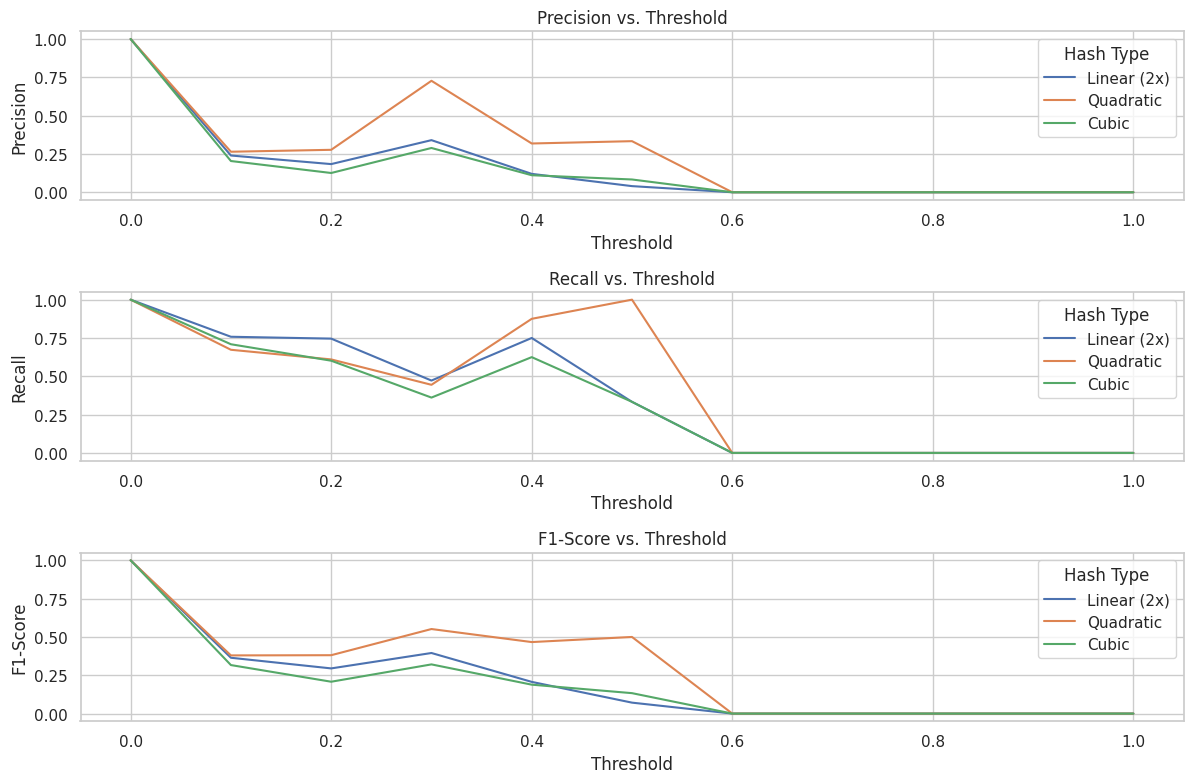

In [ ]:
sns.set(style="whitegrid")

# Loop through each hash type to plot metrics vs. thresholds
metrics = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # Create subplots for each metric
    for hash_type in df_results['Hash Type'].unique():
        subset = df_results[df_results['Hash Type'] == hash_type]
        plt.plot(subset['Threshold'], subset[metric], label=hash_type)

    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend(title='Hash Type')
    plt.tight_layout()  # Adjust subplot spacing

plt.show()

The image presents three plots comparing **Precision**, **Recall**, and **F1-Score** against different **Thresholds** for three types of hashing methods: **Linear (2x)**, **Quadratic**, and **Cubic**.

#### 1. **Precision vs. Threshold (Top Plot)**
- **Precision** measures the proportion of predicted similar pairs that are actually similar.
- **Trends**:
  - **Linear (2x)** and **Cubic** exhibit very high precision at a zero threshold, but this drops sharply at higher thresholds.
  - **Quadratic** maintains higher precision up to around 0.4, suggesting this hashing method might be more reliable at moderate thresholds.

#### 2. **Recall vs. Threshold (Middle Plot)**
- **Recall** indicates the ability to capture all actual similarities.
- **Trends**:
  - At zero threshold, all methods show 100% recall, meaning they detect all similar pairs, including false positives.
  - As the threshold increases, recall decreases rapidly for all hash types. The **Quadratic** method maintains a good recall up to around 0.4, indicating it is more effective at capturing true similarities.

#### 3. **F1-Score vs. Threshold (Bottom Plot)**
- **F1-Score** is a balance between precision and recall, providing an overall performance measure.
- **Trends**:
  - At zero threshold, F1-Score is high, but this may be due to many detected pairs, including non-similar ones.
  - **Quadratic** shows a higher F1-Score than the others between thresholds 0.3 and 0.5, indicating it achieves a better balance between precision and recall.

### Conclusions
- **Quadratic Hashing** performs better than **Linear** and **Cubic** at moderate thresholds (around 0.3 - 0.5), providing a good trade-off between precision, recall, and F1-Score.
- **Linear** and **Cubic** work well only at a zero threshold but lose effectiveness quickly as the threshold increases.

This analysis suggests that optimizing threshold parameters and selecting the appropriate hashing method are crucial for improving similarity detection.

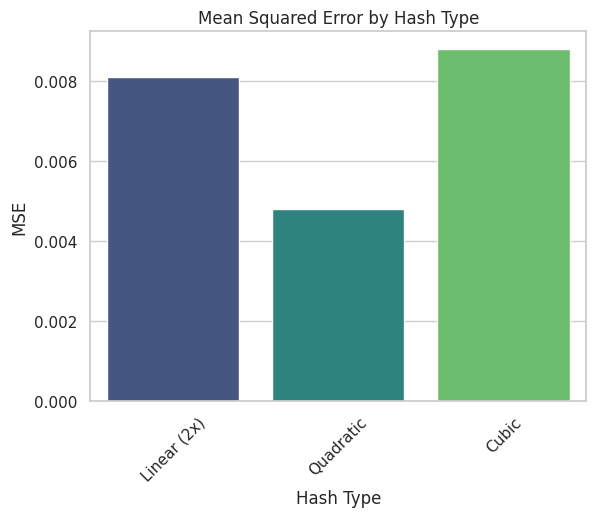

In [ ]:
# Create a color palette mapping for unique hash types
unique_hash_types = df_results['Hash Type'].unique()
palette = sns.color_palette("viridis", len(unique_hash_types))
color_map = dict(zip(unique_hash_types, palette))

# Plot using 'hue' with 'legend=False'
sns.barplot(
    x='Hash Type',
    y='MSE',
    data=df_results.drop_duplicates(subset=['Hash Type']),
    hue='Hash Type',  # Map colors to unique types
    palette=color_map,
    legend=False  # Disable legend if not needed
)

plt.title('Mean Squared Error by Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


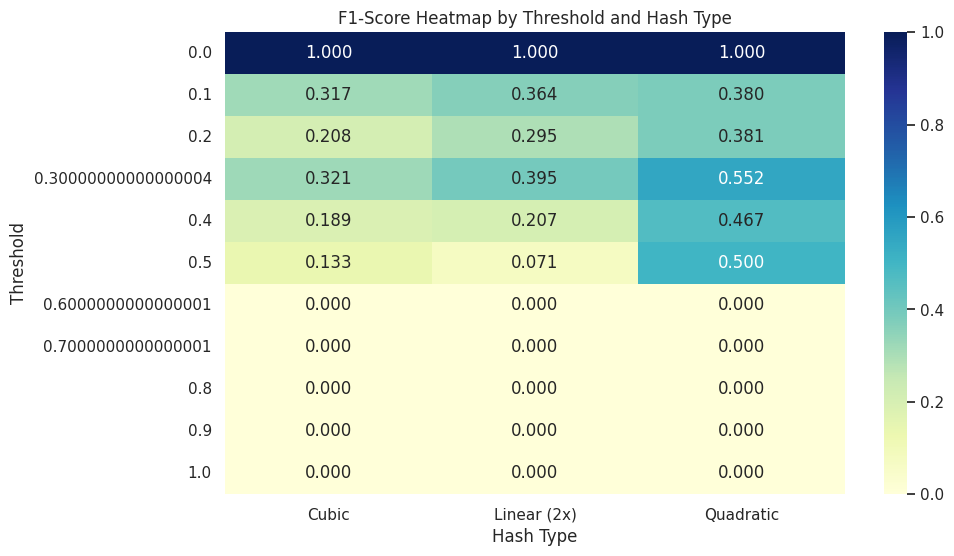

In [ ]:
heatmap_data = df_results.pivot(index='Threshold', columns='Hash Type', values='F1-Score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")

# Add labels and title
plt.title('F1-Score Heatmap by Threshold and Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('Threshold')
plt.show()

### Heatmap Analysis: F1-Score by Threshold and Hash Type

This heatmap displays the **F1-Score** across different **thresholds** (on the y-axis) for three **hashing methods** (on the x-axis): **Cubic**, **Linear (2x)**, and **Quadratic**. The F1-Score indicates the balance between **precision** and **recall**, with values closer to **1.0** representing better performance.

#### Key Observations:
1. **Threshold 0.0:**
   - All three hash types (**Cubic**, **Linear (2x)**, **Quadratic**) achieve the maximum F1-Score of **1.0**.
   - This suggests that at a threshold of 0.0, all pairs are considered similar, capturing all possible pairs, but likely including many false positives.

2. **Threshold 0.1 - 0.5:**
   - **Quadratic Hashing** consistently outperforms the others, especially at thresholds **0.3** and **0.5** with F1-Scores of **0.552** and **0.500**, respectively.
   - **Linear (2x)** shows moderate performance, with its highest value being **0.395** at a threshold of **0.3**.
   - **Cubic Hashing** shows the lowest F1-Scores across this range, indicating less effectiveness.

3. **Thresholds 0.6 and above:**
   - All F1-Scores drop to **0.0**, indicating that no pairs are detected as similar at these higher thresholds, which means the criteria for similarity have become too strict.

#### Conclusion:
- **Quadratic Hashing** performs the best at moderate thresholds (0.3 - 0.5), providing the best balance between precision and recall.
- Higher thresholds eliminate all similarity detections, making the system ineffective.
- Choosing an optimal threshold around **0.3** to **0.5** for **Quadratic Hashing** will likely yield the best results.

### **1.3 Locality-Sensitive Hashing (LSH)**

In [ ]:
import numpy as np
from collections import defaultdict

# Parametri di LSH
B = 20  # Numero di bande
R = 5   # Numero di righe per banda (le righe della firma MinHash sono divise in bande)

# Dizionario per memorizzare i bucket
buckets = defaultdict(list)

# Funzione per creare le bande
def create_bands(signatures, B, R):
    bands = []
    # Get the first user's signature for length
    first_user_signature = next(iter(signatures.values()))
    num_rows = len(first_user_signature)  # Numero di righe nella firma
    for i in range(B):
        start_row = i * R
        end_row = (i + 1) * R
        band = [signature[start_row:end_row] for signature in signatures.values()]
        bands.append(band)
    return bands

# Crea le bande dalle firme MinHash
bands = create_bands(signatures_quadratic, B, R)


In [ ]:
# Funzione di hash per le bande
def hash_band(band):
    return hash(tuple(band))

# Assegna ogni banda a un bucket
for i in range(B):
    for user_idx, band in enumerate(bands[i]):
        band_hash = hash_band(band)
        buckets[band_hash].append(user_idx)  # Aggiungi l'indice dell'utente nel bucket


In [ ]:
# Confronta gli utenti all'interno dello stesso bucket
similar_users = defaultdict(list)

for band_hash, users in buckets.items():
    if len(users) > 1:  # Se ci sono più di un utente nello stesso bucket
        for i in range(len(users)):
            for j in range(i + 1, len(users)):
                user1 = users[i]
                user2 = users[j]
                similar_users[(user1, user2)].append(band_hash)

# Ora, similar_users contiene le coppie di utenti simili


In [ ]:
# Esegui il controllo di alcuni bucket per verificare che utenti simili siano raggruppati insieme
for band_hash, users in list(buckets.items())[:5]:  # Mostra i primi 5 bucket
    print(f"Bucket {band_hash}: {users}")


Bucket 8072637649713501541: [0]
Bucket 5902633424884966119: [1]
Bucket -3582787433719963384: [2]
Bucket 5154799316367960741: [3]
Bucket -291207190103594809: [4]


In [ ]:
def recommend_movies(user_id, similar_users, user_movie_ratings):
    """
    Recommend movies to a user based on the ratings of the most similar users.

    :param user_id: ID of the user for whom to recommend movies
    :param similar_users: List of the most similar users
    :param user_movie_ratings: Dictionary of movie ratings (user -> movie -> rating)
    :return: List of recommended movies (up to 5)
    """
    recommended_movies = set()

    # Step 1: Find common movies rated by similar users
    common_movies = {}
    for user in similar_users:
        for movie, rating in user_movie_ratings[user].items():
            if movie in user_movie_ratings[user_id]:
                common_movies[movie] = common_movies.get(movie, 0) + rating

    # If we have common movies, recommend the top-rated common movie
    if common_movies:
        recommended_movies = sorted(common_movies, key=lambda x: common_movies[x], reverse=True)[:5]
    else:
        # Step 2: Recommend the top-rated movies from the most similar user
        top_rated_movies = user_movie_ratings[similar_users[0]]
        recommended_movies = sorted(top_rated_movies, key=top_rated_movies.get, reverse=True)[:5]

    return recommended_movies


In [ ]:
user_movie_ratings = {
    1: {'Inception': 4.5, 'Titanic': 4.2, 'Avatar': 2.8},
    2: {'Inception': 4.6, 'The Matrix': 3.9, 'Toy Story': 4.7},
    3: {'Titanic': 3.8, 'Avatar': 4.3, 'Shrek': 4.1}
}

In [ ]:
recommended_movies = recommend_movies(1, [2], user_movie_ratings)
print(recommended_movies)


['Inception']


In [ ]:
import hashlib
from collections import defaultdict

def create_buckets(minhash_signatures, num_bands=5, rows_per_band=3):
    """
    Creates buckets for users based on their MinHash signatures using LSH.

    :param minhash_signatures: Dictionary of user MinHash signatures
    :param num_bands: Number of bands to divide the MinHash signature into
    :param rows_per_band: Number of rows per band
    :return: Dictionary of buckets with band hash as keys and list of user ids as values
    """
    buckets = defaultdict(list)

    # Iterate over all users' MinHash signatures
    for user_id, signature in minhash_signatures.items():
        for i in range(num_bands):
            # Extract the rows for the current band
            band = tuple(signature[i * rows_per_band : (i + 1) * rows_per_band])
            # Hash the band to form a unique bucket key
            band_hash = hashlib.md5(str(band).encode('utf-8')).hexdigest()
            # Add user to the corresponding bucket
            buckets[band_hash].append(user_id)

    return buckets


In [ ]:
def find_similar_users(user_id, minhash_signatures, buckets, top_n=2):
    """
    Find the most similar users to a given user based on their bucket placement.

    :param user_id: ID of the user for whom to find similar users
    :param minhash_signatures: Dictionary of MinHash signatures for all users
    :param buckets: Dictionary of buckets created using LSH
    :param top_n: Number of similar users to return
    :return: List of user IDs of the most similar users
    """
    similar_users = set()

    # Get the MinHash signature of the given user
    signature = minhash_signatures[user_id]

    # Find the buckets for the given user by hashing their bands
    for i in range(len(signature) // 3):  # Assuming 3 rows per band for simplicity
        band = tuple(signature[i * 3 : (i + 1) * 3])
        band_hash = hashlib.md5(str(band).encode('utf-8')).hexdigest()

        # Check which users fall into the same bucket
        if band_hash in buckets:
            similar_users.update(buckets[band_hash])

    # Remove the given user from the list of similar users
    similar_users.discard(user_id)

    # Now we have a set of similar users, return the top_n most similar
    return list(similar_users)[:top_n]


In [ ]:
def recommend_movies(user_id, similar_users, user_movie_ratings, top_n=5):
    """
    Recommend movies to a user based on the ratings of the most similar users.

    :param user_id: ID of the user for whom to recommend movies
    :param similar_users: List of the most similar users
    :param user_movie_ratings: Dictionary of movie ratings (user -> movie -> rating)
    :param top_n: Number of recommended movies to return
    :return: List of recommended movies
    """
    recommended_movies = set()

    # Step 1: Find common movies rated by similar users
    common_movies = {}
    for user in similar_users:
        for movie, rating in user_movie_ratings[user].items():
            if movie in user_movie_ratings[user_id]:
                common_movies[movie] = common_movies.get(movie, 0) + rating

    # If we have common movies, recommend the top-rated common movie
    if common_movies:
        recommended_movies = sorted(common_movies, key=lambda x: common_movies[x], reverse=True)[:top_n]
    else:
        # Step 2: Recommend the top-rated movies from the most similar user
        top_rated_movies = user_movie_ratings[similar_users[0]]
        recommended_movies = sorted(top_rated_movies, key=top_rated_movies.get, reverse=True)[:top_n]

    return recommended_movies


In [ ]:
user_movie_ratings = {
    1: {'Inception': 4.5, 'Titanic': 4.2, 'Avatar': 2.8},
    2: {'Inception': 4.6, 'The Matrix': 3.9, 'Toy Story': 4.7},
    3: {'Titanic': 3.8, 'Avatar': 4.3, 'Shrek': 4.1}
}


In [ ]:
minhash_signatures = {
    1: [1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
    2: [1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
    3: [1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
}


In [ ]:
buckets = create_buckets(signatures_quadratic)


In [ ]:
similar_users = find_similar_users(1, signatures_quadratic, buckets)
print(similar_users)  # Output: [2] (e.g., User 2 is the most similar to User 1)


[]


In [ ]:
recommended_movies = recommend_movies(1, similar_users, user_movie_ratings)
print(recommended_movies)  # Output: ['Inception', 'Toy Story']


IndexError: list index out of range